In [1]:
import pandas as pd
import xarray as xr
xr.set_options(keep_attrs=True,
               display_expand_data=False)

import yfinance as yf

from data import get_factor_master


In [2]:
def out(df):
    df.sort_index(ascending=False).to_clipboard()


In [3]:
def get_yahoo_data(ticker, field_name, cache=None):
    # TODO: Check cache first
    # cache.columns.get_level_values(1)
    return yf.download(ticker)[field_name]


def get_yahoo_data_set(tickers, field_name, asset_names=None):
    if asset_names is None:
        asset_names = tickers
    return (pd.DataFrame({asset_name: get_yahoo_data(ticker, field_name) 
                         for asset_name, ticker in zip(asset_names, tickers)})
            .rename_axis(index='date', columns='factor_name'))


def fill_returns(df):
    return df.ffill()


def get_business_days(df, factor_names):
    return df[factor_names].dropna(how='any').index


def align_dates(df, business_day_factors):
    dates_raw = df.index
    dates_business = get_business_days(df, business_day_factors)
    dates_union = dates_raw.union(dates_business)
    return (df
            .reindex(dates_union)
            .pipe(fill_returns)
            .loc[dates_business])


def calculate_returns(cret, diffusion_type):
    match diffusion_type:
        case 'lognormal':
            return cret.pct_change().mul(10_000)
        case 'normal':
            return cret.diff().mul(100)
        # case 'normal10':
        #     return cret.diff().div(10)
        case _:
            raise ValueError(f'Unsupported diffusion_type of {diffusion_type} for {cret.name}')
        # case nan:
        #     raise ValueError(f'No diffusion_type provided for {cret.name}')


def calculate_returns_set(df, diffusion_map):
    return (pd.DataFrame({factor: calculate_returns(df[factor], diffusion_map[factor]) 
                          for factor in df.columns
                          })
            .rename_axis(index='date', columns='factor_name'))


In [4]:
factor_master = get_factor_master('factor_master.xlsx', 'read_new')
factor_list = factor_master.index

levels_raw = (get_yahoo_data_set(asset_names = factor_list, 
                                 tickers = factor_master.loc[factor_list, 'ticker'],
                                 field_name = 'Adj Close'))

levels = align_dates(levels_raw, ['SPX', 'USD10'])
ret = calculate_returns_set(levels, factor_master['diffusion_type'])
ret


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


factor_name,SPX,RUT,CAC,USD10,TY
date,,,,,
1993-01-29,NaN,NaN,NaN,NaN,NaN
1993-02-01,71.124453,NaN,77.305460,-0.999975,NaN
1993-02-02,21.177304,NaN,7.839321,7.999992,NaN
1993-02-03,105.716692,NaN,205.896748,-1.000023,NaN
1993-02-04,41.838975,NaN,166.109584,-5.999994,NaN
...,...,...,...,...,...
2025-01-15,181.899840,196.613510,68.591306,-13.500023,105.263898
2025-01-16,-19.231664,20.086244,214.259771,-4.699993,23.870831
2025-01-17,100.398930,43.209105,98.247960,0.300026,7.577365


# Build Dataset

In [10]:
factor_data = xr.Dataset()
factor_data['levels'] = levels.stack().to_xarray()
factor_data['ret'] = ret.stack().to_xarray()
factor_data['cret'] = factor_data['levels'].copy()
factor_data['factor_name'].attrs = factor_master.T.to_dict()

factor_data

<xarray.Dataset> Size: 1MB
Dimensions:      (date: 8030, factor_name: 5)
Coordinates:
  * date         (date) datetime64[ns] 64kB 1993-01-29 1993-02-01 ... 2025-01-22
  * factor_name  (factor_name) object 40B 'SPX' 'RUT' 'CAC' 'USD10' 'TY'
Data variables:
    levels       (date, factor_name) float64 321kB 24.53 nan ... 4.599 92.52
    ret          (date, factor_name) float64 321kB nan nan nan ... 2.5 -25.87
    cret         (date, factor_name) float64 321kB 24.53 nan ... 4.599 92.52

# Check duration

Equation of line: Y = 1.46 + -7.11X


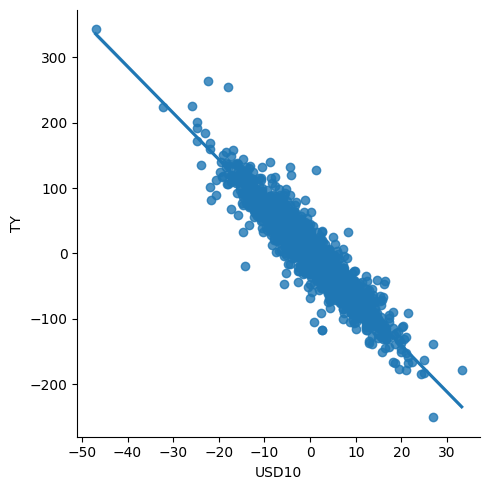

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


def regression_plot(df, x, y):
    df = df[[x, y]].dropna()
    X = df[x]
    Y = df[y]
    X = sm.add_constant(X)  # Adds a constant term to the predictor

    model = sm.OLS(Y, X).fit()
    # predictions = model.predict(X)

    # Display the equation of the line
    intercept, slope = model.params
    print(f'Equation of line: Y = {intercept:.2f} + {slope:.2f}X')

    # Create scatter plot with line of best fit
    sns.lmplot(x=x, y=y, data=df)
    plt.show()
    
    
regression_plot(ret, 'USD10', 'TY')


# Junk

In [7]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
def get_yahoo_data(ticker, field_name, cache=None):
    # TODO: Check cache first
    return yf.download(ticker)[field_name]

# cache = yf.download(factor_master['ticker'].iloc[:-1].to_list())

lvl_raw_dict = {}
for factor in factor_master.index:
    lvl_raw_dict[factor] = get_yahoo_data(factor_master.loc[factor, 'ticker'], 'Adj Close')
lvl_raw = pd.DataFrame(lvl_raw_dict)
# TODO: Confirm outer join


In [ ]:
business_days = None
df.index

In [ ]:
def my_ffill(df, business_days, method=None, na_tolerance=None, diffusion_type=None):
    # 1) Include business_days in df index
    
    if business_days is None:
        full_dates = df.index.union(business_days)
        df = df.reindex(full_dates)
    # 2) Count consecutive NAs
    # 3) Extract dates with NAs and their count (build replacement dataframe)
    # 4) If consecutive NAs < na_tolerance, replacement data = 0 (for now) else nan
    # 5) Forward fill
    # 6) Add replacement (respecting diffusion_type)
    return df


def get_business_days(df, factors=['SPX']):
    return df[factors].dropna(how='any').index


def calculate_returns(levels, diffusion_type):
    if diffusion_type == 'diff':
        return levels.diff()
    elif diffusion_type == 'pct':
        return levels.pct_change()
    else:
        raise ValueError('diffusion_type must be either "diff" or "pct"')

In [ ]:
my_ffill(lvl_raw, get_business_days(lvl_raw))

In [ ]:
import pandas as pd
import numpy as np

# Create a date range for the last three days
data = [100, np.nan, np.nan, 101]
date_range = pd.date_range(end=pd.Timestamp.today().date(), periods=len(data))


# Create a dataframe with the specified values
data = [100, np.nan, np.nan, 101]
df = pd.Series(data, index=date_range) #, columns=['Value'])

# pd.concat([df, df.pct_change()], axis=1)

df

In [ ]:


asset_list = ['SPY', 'IWM', 'IEF', '^TNX', '^FCHI']
diffusion_types = ['lognormal', 'lognormal', ]
data = yf.download(asset_list)

lvl = data['Adj Close']
lvl.pipe(out)

ret = lvl.pct_change().pipe(out)
# Union any other data sources




In [ ]:
my_ffill(lvl_raw, get_business_days(lvl_raw))

In [ ]:
import pandas as pd
import numpy as np

# Create a date range for the last three days
data = [100, np.nan, np.nan, 101]
date_range = pd.date_range(end=pd.Timestamp.today().date(), periods=len(data))


# Create a dataframe with the specified values
data = [100, np.nan, np.nan, 101]
df = pd.Series(data, index=date_range) #, columns=['Value'])

# pd.concat([df, df.pct_change()], axis=1)

df

In [ ]:
import pandas as pd

print(pd.__version__)


In [ ]:
import pandas as pd
current_date = pd.Timestamp.today().date()
print(current_date)
